# Import libs

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1057: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from skimage import io, transform
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from pylab import rcParams


rcParams['figure.figsize'] = 10, 10


plt.ion()   # interactive mode

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.set_device(0)

# Load data

In [4]:
class CsvDataset(Dataset):
    def __init__(self, label_df, classes, class_indexes, root_dir, transform=None):
        self.label_frame = label_df
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.class_indexes = class_indexes

    def __len__(self):
        return len(self.label_frame) - 1

    def __getitem__(self, idx):
        label = self.label_frame.iloc[idx, 1]
        img_path = os.path.join(self.root_dir, self.label_frame.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.class_indexes[label]

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(350),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
#         transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = './data/dogbreeds'
label_csv = 'labels.csv'
label_df = pd.read_csv(f'{data_dir}/{label_csv}')


classes = list(label_df.breed.unique())
class_indexes = {classes[i]: i for i in range(0, len(classes))}
class_names = classes


train, val = train_test_split(label_df, test_size=0.2)
image_datasets = {'train': CsvDataset(train, classes, class_indexes, f'{data_dir}/train', data_transforms['train']),
                 'val': CsvDataset(val, classes, class_indexes, f'{data_dir}/train', data_transforms['val'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# View images

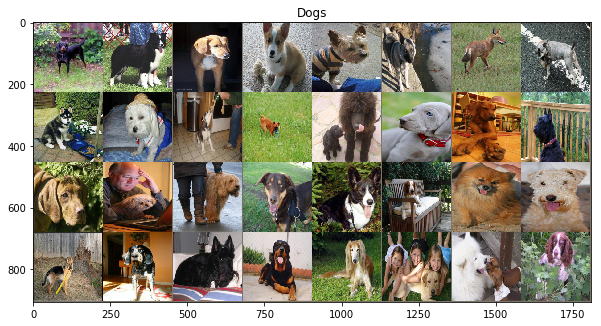

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# batch size x rgb x width x height
out = torchvision.utils.make_grid(inputs)
imshow(out, title='Dogs')
# for i in range(0, 10):
#     plt.imshow(np.asarray(Image.open(img_paths[i], 'r')))
#     imshow(inputs[i], title='{} - file: {}'.format(class_names[classes[i]], img_paths[i]))
#     imshow(inputs[i], title='{}'.format(class_names[classes[i]]))

# Train the model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] #* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model

In [8]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]], class_names[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Build Model

In [9]:
class AwesomeLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        x = self.dropout1(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [12]:
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))

# for param in model.parameters():
#     param.requires_grad = False

# if use_gpu:
#     model = model.cuda()

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, len(class_names))
model.classifier = AwesomeLayer(num_ftrs, len(class_names))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.classifier.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_gpu:
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
# train_model(model, criterion, optimizer, epochs=5)

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)
torch.save(model, 'dogbreeds-1-awesome.pt')

Epoch 0/19
----------
train Loss: 0.0672 Acc: 0.5572
Time elapsed 2m 27s
val Loss: 0.0284 Acc: 0.7960
Time elapsed 3m 3s

Epoch 1/19
----------
train Loss: 0.0231 Acc: 0.8224
Time elapsed 5m 30s
val Loss: 0.0209 Acc: 0.8209
Time elapsed 6m 6s

Epoch 2/19
----------
train Loss: 0.0170 Acc: 0.8563
Time elapsed 8m 33s
val Loss: 0.0190 Acc: 0.8195
Time elapsed 9m 9s

Epoch 3/19
----------
train Loss: 0.0135 Acc: 0.8866
Time elapsed 11m 36s
val Loss: 0.0183 Acc: 0.8356
Time elapsed 12m 12s

Epoch 4/19
----------


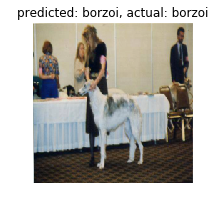

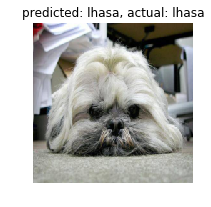

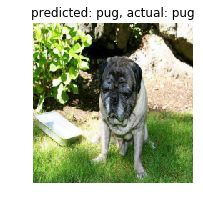

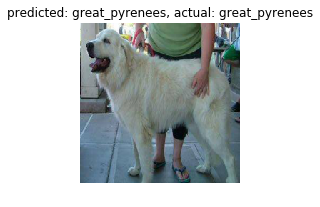

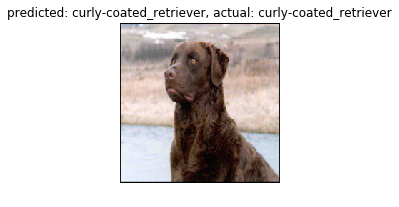

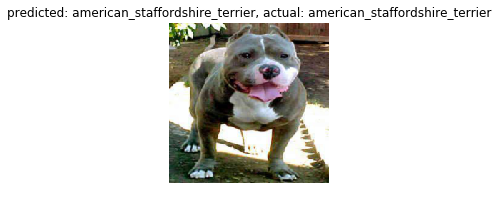

In [19]:
visualize_model(model, num_images=6)

In [15]:
def visualize_errors(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            if class_names[preds[j]] != class_names[labels.data[j]]:                
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]], class_names[labels.data[j]]))
                imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

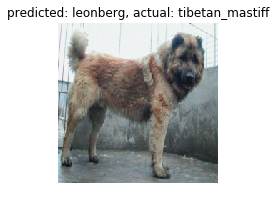

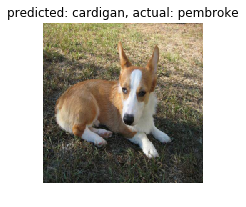

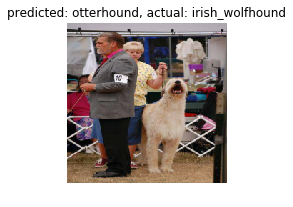

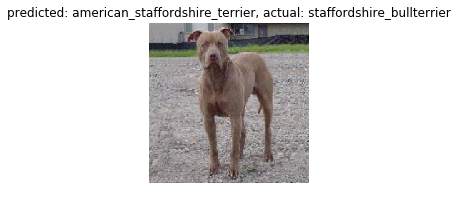

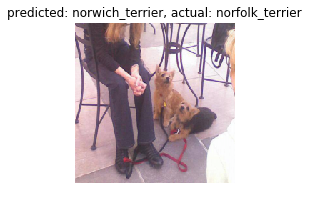

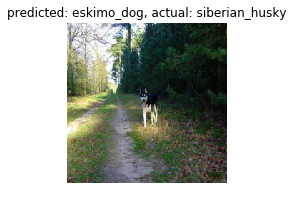

In [16]:
visualize_errors(model)

In [11]:
# model = torch.load('dogbreeds-1.pt')
model = torch.load('dogbreeds-1-awesome.pt')

# Allow backprop into pretrained model
for param in model.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)
torch.save(model, 'dogbreeds-2-awesome.pt')

Epoch 0/4
----------
train Loss: 0.0119 Acc: 0.8810
Time elapsed 7m 13s


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58